---
<h1 align=center><strong><em>NLP pour l’analyse de critiques de films</em></strong></h1>

---

## _En règle générale, le nombre d'avis sur un film peu être important et par conséquent le temps de lecture de chaque commentaire peut être une tâche lourde. Alors comment déterminer de manière rapide si un film a eu du succès auprès des spectateurs (ou pas) ? Dans ce contexte, l’idée du projet est d’utiliser des algorithmes d'apprentissage automatique pour la tâche d'analyse de sentiment des spectateurs via leur critique._

## _Tout d’abord, il sera question que récupérer les données directement du site d’Allociné. En d’autres termes, nous allons scraper les pages qui nous intéressent sur ce site à savoir les critiques des personnes pour le film Inception et Sonic 2._

## _En navigant sur la page des critiques, vous vous apercevrez que seules deux types d’information ici nous intéresse : la note du spectateur ainsi que son avis. Pourquoi la note ? Parce que nous allons entraîner un modèle de type supervisé et plus précisément un classifieur et donc la note va nous aider à récupérer la classe pour étiqueter le commentaire. Pour cela, nous considérerons qu’une note au-dessus de 3 est considérée comme satisfaisante. Sinon, l’avis est négatif. Ici, nous avons donc réduit le problème à une classification binaire._

## _Voici donc les étapes à réaliser : • Récupération des données • Préparation des données. • Préparation du modèle et des jeux de données (entrainement & test) • Analyse des résultats_

# ___Importation des librairies___

In [166]:
from bs4 import BeautifulSoup
import requests
import csv
import mysql.connector as mysqlpy

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("talk")
sns.set_style("darkgrid")
from wordcloud import WordCloud

import pandas as pd 

import nlpaug.augmenter.word as naw

from sklearn.model_selection import train_test_split

from PIL import Image
import joblib



# ___Configuration de la base données___

In [167]:
user = 'root'
password = 'example'
host = 'localhost'
port = '3307'
database = 'flask_tuto'

bdd = mysqlpy.connect(user=user, password=password, host=host, port=port, database=database)
cursor = bdd.cursor()

# ___Scrapping et récupération des données en BDD et fichier CSV___

### Code mis en commentaire aprés avoir réalisé le scrapping car le temps de récupération et de stockage est d'environ 7 minutes

In [168]:
'''
urls_pages=[["https://www.allocine.fr/film/fichefilm-281203/critiques/spectateurs/?page=",14],  # SONIC
                    ["https://www.allocine.fr/film/fichefilm-143692/critiques/spectateurs/?page=",480]] # Inception
                    
for film in urls_pages:
    for page in range(1,film[1]):
        url = f"{film[0]}{page}"
        reponse=requests.get(url)
        soup = BeautifulSoup(reponse.text,"html.parser")
        donnees=soup.find_all("div", {"class":"hred review-card cf"})

        for comment in donnees:
            id_com = comment.get("id").split("_")[1]
            note= comment.find("span",{"class":"stareval-note"}).text.replace(",",".")
            commentaire = comment.find("div",{"class":"content-txt review-card-content"}).text.replace("'"," ").replace("\n","")
            
            with open('data2.csv','a',newline='') as fichiercsv:
                writer=csv.writer(fichiercsv)
                writer.writerow([id_com,commentaire,note])
            
            query =f"""INSERT INTO allo_cine(id_comment, commentaire, note) """
            query += f"""VALUES ('{id_com}','{commentaire}',{note})"""
            query += f"""ON DUPLICATE KEY UPDATE id_comment='{id_com}' """
            cursor.execute(query)
        bdd.commit()
'''

'\nurls_pages=[["https://www.allocine.fr/film/fichefilm-281203/critiques/spectateurs/?page=",14],  # SONIC\n                    ["https://www.allocine.fr/film/fichefilm-143692/critiques/spectateurs/?page=",480]] # Inception\n                    \nfor film in urls_pages:\n    for page in range(1,film[1]):\n        url = f"{film[0]}{page}"\n        reponse=requests.get(url)\n        soup = BeautifulSoup(reponse.text,"html.parser")\n        donnees=soup.find_all("div", {"class":"hred review-card cf"})\n\n        for comment in donnees:\n            id_com = comment.get("id").split("_")[1]\n            note= comment.find("span",{"class":"stareval-note"}).text.replace(",",".")\n            commentaire = comment.find("div",{"class":"content-txt review-card-content"}).text.replace("\'"," ").replace("\n","")\n            \n            with open(\'data2.csv\',\'a\',newline=\'\') as fichiercsv:\n                writer=csv.writer(fichiercsv)\n                writer.writerow([id_com,commentaire,no

# ___Récupération en dataframe___

In [169]:
df = pd.read_csv("data2.csv", names=["id","commentaire","note"])
df.head()

,id,commentaire,note
0,1019557672,une bonne suite pour les aventures de sonic au...,4.0
1,1019620791,Cette suite de sonic est incroyable !Le fan qu...,5.0
2,1019619517,Très bon film ont retrouve ce qui fait l’espri...,4.5
3,1019622008,"Super film de ouf, le fait que Knuckles soit d...",4.0
4,1019649095,Malgré deux nouveaux personnages de l univers ...,3.0


In [170]:
print(df.shape)
df.isna().sum()

(7365, 3)


id             0
commentaire    1
note           0
dtype: int64

In [171]:
df.dropna(inplace=True)

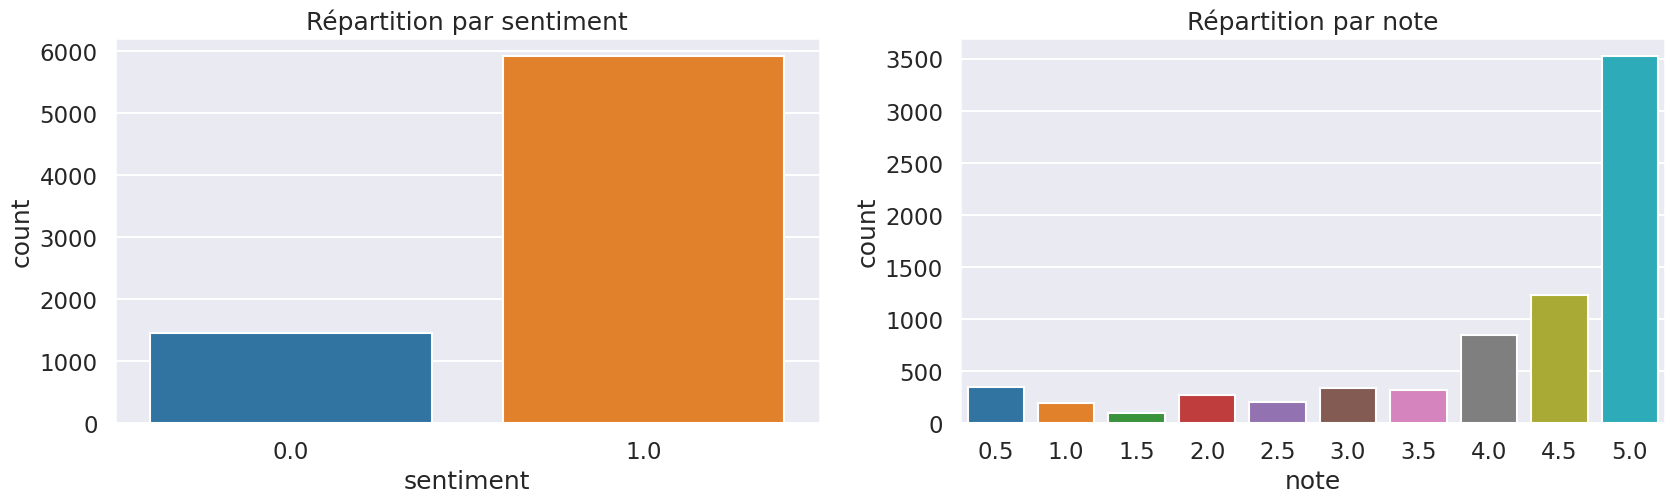

In [172]:
df.loc[(df.note>3),'sentiment']=1
df.loc[(df.note<=3),'sentiment']=0

f,ax=plt.subplots(1,2,figsize=(20,5))
sns.countplot(data=df, x=df.sentiment, ax=ax[0])
ax[0].set(title="Répartition par sentiment")
sns.countplot(data=df, x=df.note, ax=ax[1])
ax[1].set(title="Répartition par note")
plt.show()


In [173]:
df["sentiment"].value_counts()

1.0    5910
0.0    1454
Name: sentiment, dtype: int64

### Il y a une grande disparité entre les avis positif et négatif => on va créer des avis négatif à partir de avis existants et nous allons supprimer des avis positifs pour équilibrer les données

In [174]:
# Recherche par tatonnement pour ne garder qu'environ 4000 commentaires négatif
# Soit une suppresseion d'environ 3500 commentaires positifs
#df[(df['note'] >=4.5) & (df.index<5000)].shape

In [175]:

# df.drop(df[(df['note'] >=4.5) & (df.index<5000)].index, inplace=True)
# print(df.sentiment.value_counts())

# f,ax=plt.subplots(1,2,figsize=(20,5))
# sns.countplot(data=df, x=df.sentiment, ax=ax[0])
# ax[0].set(title="Répartition par sentiment")
# sns.countplot(data=df, x=df.note, ax=ax[1])
# ax[1].set(title="Répartition par note")
# plt.show()

# ___Ajout de plus de commentaire négatif___

In [176]:
print(df.sentiment.value_counts())

1.0    5910
0.0    1454
Name: sentiment, dtype: int64


# ___Split du dataframe___

In [177]:
X_train, X_test, y_train, y_test = train_test_split(df.commentaire, df.sentiment, test_size=0.2, random_state=42)

In [178]:
print(y_train.value_counts())

1.0    4732
0.0    1159
Name: sentiment, dtype: int64


### __Il y a trois fois moins de commentaire négatif dans notre jeu d'entrainement donc il va falloir utiliser la data augmentation pour l'équilibrer__

# __Augmentation du nombre d'avis négatif__

### __Pour augmenter le jeu de test la technique utilisée sera la back translation avec une traduction en Anglais et en allemand avec un retour en français.__

In [179]:
import numpy as np
from googletrans import Translator
'''
def back_translate(sequence, langue):
    translator = Translator()
    #translate to new language and back to original
    translated = translator.translate(sequence, dest = langue).text
    #translate back to original language
    translated_back = translator.translate(translated, dest = 'fr').text
    return translated_back

count= X_train[y_train==0].shape[0]*3
langue=['en','nl']
for i in langue:
    for commentaire in X_train[y_train == 0]:
        output_translate = back_translate(commentaire, i)
        X_train = pd.concat([X_train,pd.Series(output_translate)])
        y_train = pd.concat([y_train,pd.Series(0)])
        print(count)
        count-=1
'''


"\ndef back_translate(sequence, langue):\n    translator = Translator()\n    #translate to new language and back to original\n    translated = translator.translate(sequence, dest = langue).text\n    #translate back to original language\n    translated_back = translator.translate(translated, dest = 'fr').text\n    return translated_back\n\ncount= X_train[y_train==0].shape[0]*3\nlangue=['en','nl']\nfor i in langue:\n    for commentaire in X_train[y_train == 0]:\n        output_translate = back_translate(commentaire, i)\n        X_train = pd.concat([X_train,pd.Series(output_translate)])\n        y_train = pd.concat([y_train,pd.Series(0)])\n        print(count)\n        count-=1\n"

In [180]:
'''
model_complet={ "Xtrain_translate":X_train,
                "ytrain_translate":y_train,
                }

joblib.dump(model_complet, 'brief_nlp_joblib.joblib')
'''

'\nmodel_complet={ "Xtrain_translate":X_train,\n                "ytrain_translate":y_train,\n                }\n\njoblib.dump(model_complet, \'brief_nlp_joblib.joblib\')\n'

In [181]:
X_train = joblib.load('brief_nlp_joblib.joblib')['Xtrain_translate']
y_train = joblib.load('brief_nlp_joblib.joblib')['ytrain_translate']

In [182]:
print(y_train.value_counts())

1.0    4732
0.0    4636
dtype: int64


### ___Le jeu d'entrainemant est maintenant bien équilibré___

# ___Standardisation du dataset___

In [183]:
def standardize_text(donnees):
    donnees = donnees.str.replace(r"http\S+", "",regex=True)
    donnees = donnees.str.replace(r"http", "",regex=True)
    donnees = donnees.str.replace(r"@\S+", "",regex=True)
    donnees = donnees.str.replace(r"[0-9(),;!:?@<>.=\'\`\"\-\_\n]", " ",regex=True)
    donnees = donnees.str.replace(r"@", "at",regex=True)
    donnees = donnees.str.replace("é", "e")
    donnees = donnees.str.replace("è", "e")
    donnees = donnees.str.lower()
    return donnees

X_train = standardize_text(X_train)

In [184]:
X_train

3443    quelle pretention de la part de nolan  son fil...
5474    un regal      j y suis allee avec plusieurs am...
6696    bravo    tres bon film au scenario incroyable ...
5409    un sujet auquel certains chefs d oeuvres tels ...
2802    comme espere dans mes rêves         enorme       
                              ...                        
0       tres deçue par ce film  j avais envie de dormi...
0       film long  bavard  inutile et surtout brouillo...
0       une grosse deception  et pourtant j avais hâte...
0       complique au debut  le film nous captive ensui...
0       tout l arsenal des nouvelles technologies est ...
Length: 9368, dtype: object

# ___Création des stopwords___

## __Ici la création d'une de stopword qui contient les mots présent dans les commentaires négatif ET positif détériore la qualité du model donc on utilisera cette liste de stopwords uniquement pour le nuage de mots__ 

In [185]:
# Création d'une liste de stopwords
# Si un mot et compris dans un commentaire positif ET négatif
# Alors il sera inclu dans la liste
'''
mots_neg, mots_pos, liste_stopwords=[],[],[]
for i in X_train[y_train == 0]:
    neg = i.split()
    mots_neg+=neg
for i in X_train[y_train == 1]:
    pos = i.split()
    mots_pos+=pos

liste_stopwords = list(set(mots_neg) & (set(mots_pos)))
liste_stopwords += ["call","duty","modern","warfare","natasha",'rothwell']
'''


'\nmots_neg, mots_pos, liste_stopwords=[],[],[]\nfor i in X_train[y_train == 0]:\n    neg = i.split()\n    mots_neg+=neg\nfor i in X_train[y_train == 1]:\n    pos = i.split()\n    mots_pos+=pos\n\nliste_stopwords = list(set(mots_neg) & (set(mots_pos)))\nliste_stopwords += ["call","duty","modern","warfare","natasha",\'rothwell\']\n'

# ___Lemming___

In [186]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from french_lefff_lemmatizer.french_lefff_lemmatizer import FrenchLefffLemmatizer

liste_stopwords=stopwords.words('french')
def tokenisation(donnees,liste_stopwords):
    lemmatizer = FrenchLefffLemmatizer()
    corpus = []
    exclusion = stopwords.words('french')+liste_stopwords
    
    for i in range(0, len(donnees)):
        message = donnees.iloc[i]
        message = message.split()
        message =[word for word in message if word not in exclusion]
        message = [lemmatizer.lemmatize(word) for word in message]
        message = ' '.join(message)
        corpus.append(message)
    
    return corpus


# ___Vectorisation___

In [187]:
from sklearn.feature_extraction.text import TfidfVectorizer

corpus_xtrain=tokenisation(X_train, liste_stopwords)
corpus_xtest=tokenisation(X_test, liste_stopwords)

vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(corpus_xtrain)
X_test_vec = vectorizer.transform(corpus_xtest)

# ___Regression logistique___

L'accuaracy score est de : 0.868295994568907


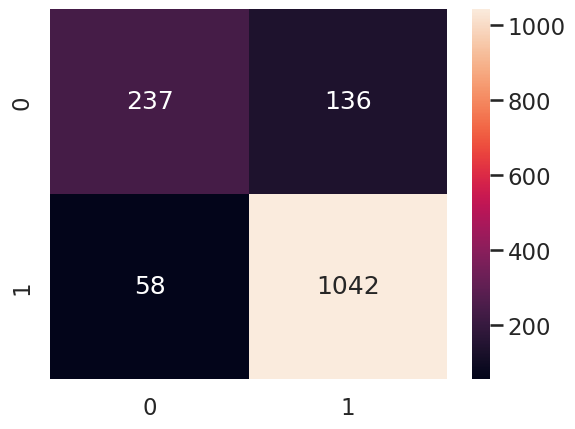

In [188]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

LReg = LogisticRegression(random_state=42)
LReg.fit(X_train_vec, y_train)
y_pred = LReg.predict(X_test_vec)

accuaracy = accuracy_score(y_pred, y_test)
print("L'accuaracy score est de :", accuaracy)
cm = confusion_matrix(y_pred, y_test)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

# ___Multinomial Naive bayes___

L'accuaracy score est de : 0.8370672097759674


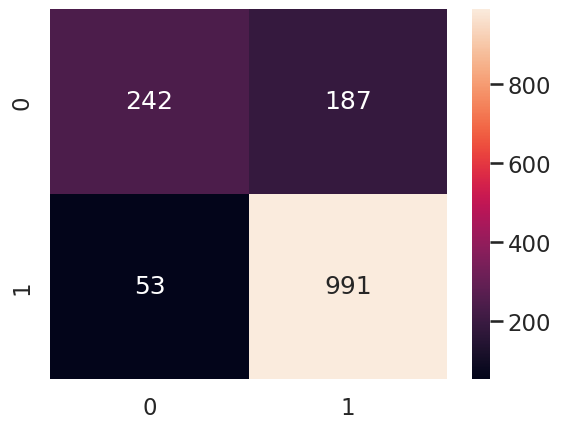

In [189]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB().fit(X_train_vec, y_train)
y_pred = clf.predict(X_test_vec)

print("L'accuaracy score est de :", accuracy_score(y_pred, y_test))
cm = confusion_matrix(y_pred, y_test)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

# ___Voting___


L'accuaracy score est de : 0.8221317040054311


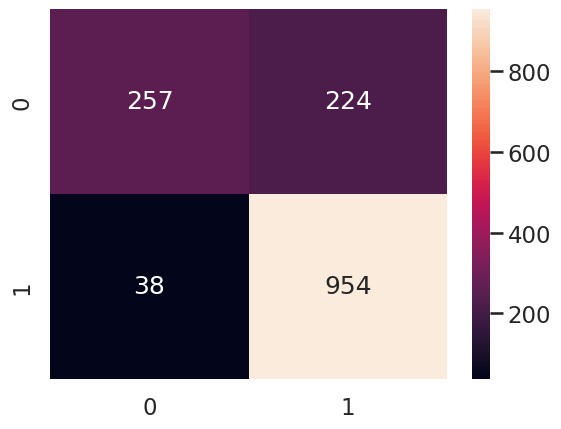

In [190]:
from sklearn.ensemble import VotingClassifier

clf1 = LogisticRegression(random_state=0).fit(X_train_vec, y_train)
clf2 = MultinomialNB().fit(X_train_vec, y_train)

eclf1 = VotingClassifier(estimators=[
         ('logisticREgression', clf1), ('Multinomial',clf2)], voting='hard')
eclf1 = eclf1.fit(X_train_vec, y_train)
y_pred = eclf1.predict(X_test_vec)

print("L'accuaracy score est de :", accuracy_score(y_pred, y_test))
cm = confusion_matrix(y_pred, y_test)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

In [191]:
mots_neg, mots_pos, liste_stopwords=[],[],[]
for i in X_train[y_train == 0]:
    neg = i.split()
    mots_neg+=neg
for i in X_train[y_train == 1]:
    pos = i.split()
    mots_pos+=pos

liste_stopwords = list(set(mots_neg) & (set(mots_pos)))
liste_stopwords += ["call","duty","modern","warfare","natasha",'rothwell',"lewitt","decrire","date"]

# ___Wordcloud sur le jeu d'entrainement___

Wordcloud sur toutes les commentaires


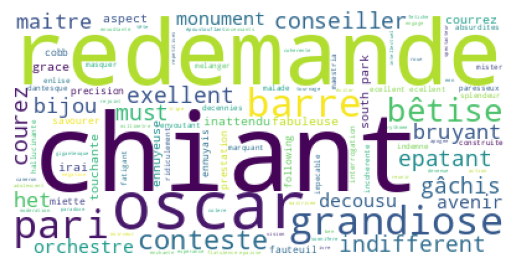

'\nmask = np.array(Image.open("app/static/images/p_vert.png"))\nmask = Image.fromarray(np.flipud(mask)).save("app/static/images/p_bas.png")\nmask = np.array(Image.open("app/static/images/p_bas.png"))\nmask[mask == 1] = 255\nprint("Wordcloud sur les commentaires négatif")\nwordcloud_neg = WordCloud(background_color = \'white\', mask=mask, max_words = 100,min_word_length=3).generate(" ".join(tokenisation(X_train[y_train == 0], liste_stopwords))+" ")\nplt.imshow(wordcloud_neg)\nplt.axis("off")\nplt.savefig("app/static/images/p__words_rouge.png")\nplt.show()\n\nmask = np.array(Image.open("app/static/images/p_vert.png"))\nmask[mask == 1] = 255\nprint("Wordcloud sur les commentaires positif")\nwordcloud_pos = WordCloud(background_color = \'white\', mask=mask, max_words = 100,min_word_length=3).generate(" ".join(tokenisation(X_train[y_train == 1], liste_stopwords))+" ")\nplt.imshow(wordcloud_pos)\nplt.axis("off")\nplt.savefig("app/static/images/p__words_vert.png")\nplt.show()\n'

In [200]:

print("Wordcloud sur toutes les commentaires")
wordcloud_all = WordCloud(background_color = 'white', max_words = 100,min_word_length=3).generate(" ".join(tokenisation(X_train, liste_stopwords))+" ")
plt.imshow(wordcloud_all)
plt.title(label="")
plt.axis("off")
plt.savefig("app/static/images/all_words.png")
plt.show()
'''
mask = np.array(Image.open("app/static/images/p_vert.png"))
mask = Image.fromarray(np.flipud(mask)).save("app/static/images/p_bas.png")
mask = np.array(Image.open("app/static/images/p_bas.png"))
mask[mask == 1] = 255
print("Wordcloud sur les commentaires négatif")
wordcloud_neg = WordCloud(background_color = 'white', mask=mask, max_words = 100,min_word_length=3).generate(" ".join(tokenisation(X_train[y_train == 0], liste_stopwords))+" ")
plt.imshow(wordcloud_neg)
plt.axis("off")
plt.savefig("app/static/images/p__words_rouge.png")
plt.show()

mask = np.array(Image.open("app/static/images/p_vert.png"))
mask[mask == 1] = 255
print("Wordcloud sur les commentaires positif")
wordcloud_pos = WordCloud(background_color = 'white', mask=mask, max_words = 100,min_word_length=3).generate(" ".join(tokenisation(X_train[y_train == 1], liste_stopwords))+" ")
plt.imshow(wordcloud_pos)
plt.axis("off")
plt.savefig("app/static/images/p__words_vert.png")
plt.show()
'''

# ___Joblib___

In [193]:
model_complet={ "Xtrain_translate":X_train,
                "ytrain_translate":y_train,
                "vector": vectorizer,
                "model":LReg,
                }

joblib.dump(model_complet, 'brief_nlp_joblib.joblib')

['brief_nlp_joblib.joblib']

[1.]
